In [253]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from ydata_profiling import ProfileReport
import joblib
from sklearn.utils import resample


In [197]:
df=pd.read_csv('Financial_inclusion_dataset.csv')

In [198]:
#rapport=ProfileReport(df, title="Profiling_Report", explorative=True)
#rapport.to_file("profiling_report.html")

In [199]:
df.shape

(23524, 13)

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [201]:
df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [202]:
df.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [203]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
df.shape

0


(23524, 13)

In [204]:
df.isna().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [205]:
#Encodage des varibles categorielles 
for col in df.columns:
    if df[col].dtype == 'object':
        df[col]=df[col].astype('category').cat.codes
df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0,2018,0,1,0,1,3,24,0,5,2,3,9
1,0,2018,1111,0,0,0,5,70,0,1,4,0,4
2,0,2018,2222,1,1,1,5,26,1,3,3,5,9
3,0,2018,3333,0,0,1,5,34,0,1,2,2,3
4,0,2018,4444,0,1,0,8,26,1,0,3,2,5


Text(0.5, 1.0, 'Correlation Matrix')

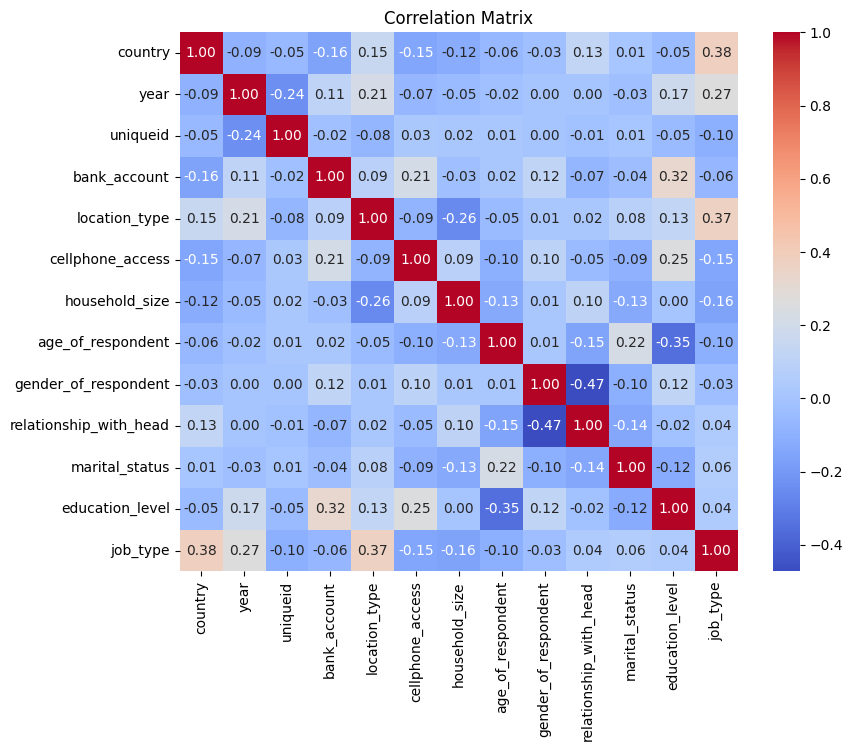

In [206]:
cm=df.corr()
plt.figure(figsize=(9,7))  
sns.heatmap(cm,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('Correlation Matrix')

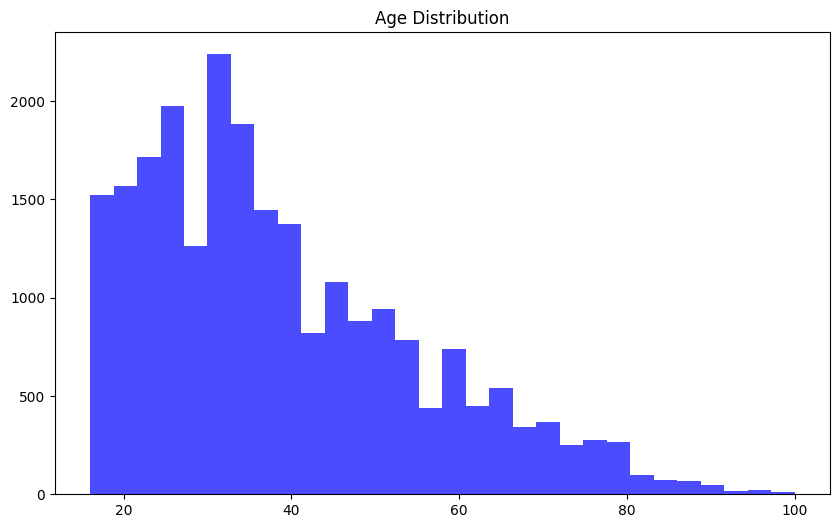

In [207]:
plt.figure(figsize=(10, 6))
plt.hist(df['age_of_respondent'], bins=30, color='blue', alpha=0.7)
plt.title('Age Distribution')   

plt.show()

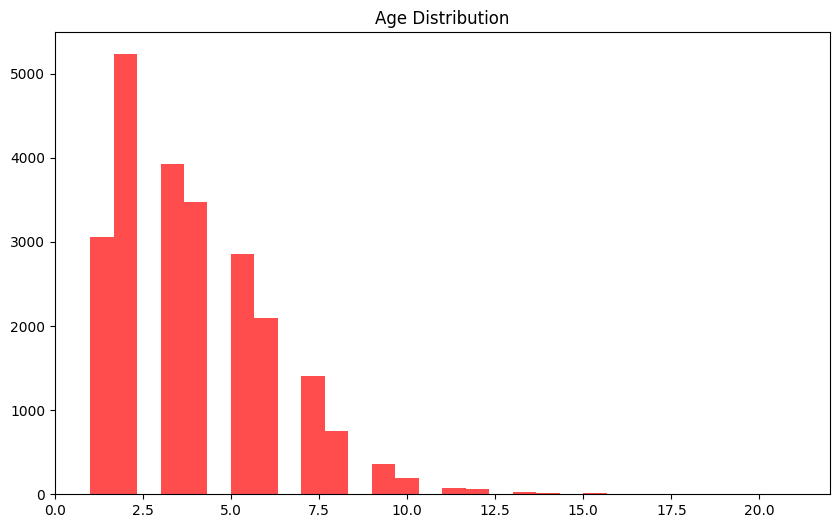

In [208]:
plt.figure(figsize=(10, 6))
plt.hist(df['household_size'], bins=30, color='red', alpha=0.7)
plt.title('Age Distribution')  
plt.show()

In [209]:
df['bank_account'].value_counts()

bank_account
0    20212
1     3312
Name: count, dtype: int64

### les données de notre variable target sont déséquilibrées ce qui peut empêcher le modele de predire correctement la classe minoritaire .Nous allons donc utiliser la methode resample pour équilibrer les données de notre variable target.

In [210]:
# Séparation des classes majoritaire et minoritaire
classe_majoritaire = df[df['bank_account'] == 0]
classe_minoritaire = df[df['bank_account'] == 1]

In [211]:
#Sous-échantillonnage de la classe majoritaire
classe_majoritaire_downsampled = resample(classe_majoritaire,replace=False,n_samples=len(classe_minoritaire),random_state=42)
df = pd.concat([classe_majoritaire_downsampled, classe_minoritaire])

In [212]:
df['bank_account'].value_counts()

bank_account
0    3312
1    3312
Name: count, dtype: int64

In [215]:
X=df.drop(columns=['bank_account','country','year','uniqueid'],axis=1)
y = df['bank_account']


In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [217]:
y_train.value_counts()

bank_account
1    2668
0    2631
Name: count, dtype: int64

In [244]:
rf_model = RandomForestClassifier(n_estimators=200,min_samples_split=10,max_depth=10,random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=200,
                       random_state=42)

In [245]:
y_pred = rf_model.predict(X_test)

In [246]:
rf_model.score(X_test, y_test)

0.7652830188679245

In [247]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.7652830188679245
Precision: 0.7638668779714739
Recall: 0.7484472049689441
F1 Score: 0.756078431372549


In [248]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.78      0.77       681
           1       0.76      0.75      0.76       644

    accuracy                           0.77      1325
   macro avg       0.77      0.76      0.76      1325
weighted avg       0.77      0.77      0.77      1325



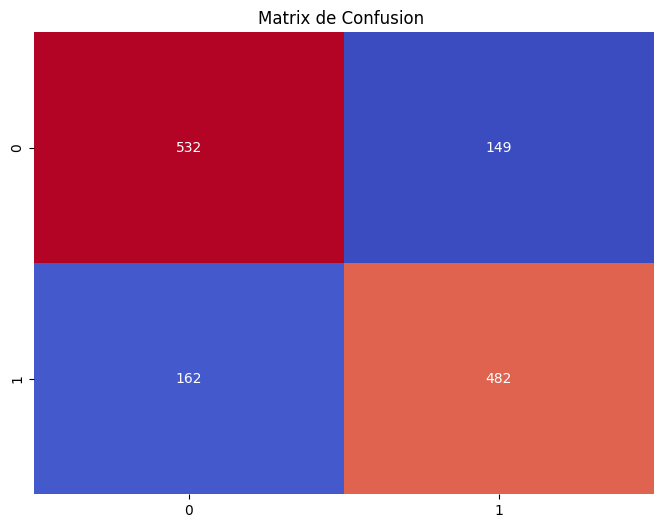

In [249]:
matrix=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='coolwarm', cbar=False)

plt.title('Matrix de Confusion ')
plt.show()

In [250]:
joblib.dump(rf_model,"bank_model.pkl")

['bank_model.pkl']

### Recherche des meilleurs hyperparametres

In [251]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


In [252]:
random_search = RandomizedSearchCV(estimator=rf_model,param_distributions=param_grid,n_iter=10,scoring='f1',cv=5,random_state=42)                                                
random_search.fit(X_train, y_train)
print("Meilleurs hyperparamètres :", random_search.best_params_)
print("Meilleur score F1 :", random_search.best_score_)


Meilleurs hyperparamètres : {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 10}
Meilleur score F1 : 0.7552114993648134
